# Drive connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
import random
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import  LinearRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from sklearn.utils import compute_class_weight

from sklearn.decomposition import PCA

# Import Dataset

In [ ]:
tracks = pd.read_csv('./drive/MyDrive/colab/bitirme/dataset/tracks.csv')

# 1980 öncesi şarkılar silindi

In [ ]:
tracks['release_date'] = np.where(tracks['release_date'].str.len() > 4, tracks['release_date'].str.slice(start=0, stop=4), tracks['release_date']).astype(str).astype(int)
before1922 = tracks[tracks['release_date'].astype(int) < 1980].index
tracks.drop(before1922, inplace=True)
tracks = tracks.reset_index(drop=True)

In [ ]:
tracks_1980s = tracks[(tracks['release_date'].astype(int) < 1990)].reset_index(drop=True)
tracks_1990s = tracks[(tracks['release_date'].astype(int) < 2000) & (tracks['release_date'].astype(int) >= 1990)].reset_index(drop=True)
tracks_2000s = tracks[(tracks['release_date'].astype(int) < 2010) & (tracks['release_date'].astype(int) >= 2000)].reset_index(drop=True)
tracks_2010s = tracks[(tracks['release_date'].astype(int) >= 2010)].reset_index(drop=True)

In [ ]:
tracks_1980s.describe()

,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,74918.000000,7.491800e+04,74918.000000,74918.000000,74918.000000,74918.000000,74918.000000,74918.000000,74918.000000,74918.000000,74918.000000,74918.000000,74918.000000,74918.000000,74918.000000,74918.000000
mean,25.467791,2.402215e+05,0.011386,1984.749927,0.552535,0.560731,5.198537,-11.024622,0.669625,0.062401,0.385497,0.089204,0.205667,0.580751,120.734367,3.896941
std,13.558076,1.006114e+05,0.106096,2.936146,0.164732,0.240707,3.538637,4.655679,0.470351,0.072908,0.318239,0.231051,0.179689,0.262496,28.537559,0.399107
min,0.000000,3.004000e+04,0.000000,1980.000000,0.000000,0.000126,0.000000,-46.825000,0.000000,0.000000,0.000000,0.000000,0.009860,0.000000,0.000000,0.000000
25%,15.000000,1.890000e+05,0.000000,1982.000000,0.442000,0.381000,2.000000,-13.490000,0.000000,0.032500,0.075500,0.000000,0.091300,0.367000,99.860250,4.000000
50%,24.000000,2.304400e+05,0.000000,1985.000000,0.566000,0.565000,5.000000,-10.562000,1.000000,0.040200,0.331000,0.000075,0.136000,0.605500,119.828000,4.000000
75%,34.000000,2.765715e+05,0.000000,1987.000000,0.671000,0.756000,9.000000,-7.699000,1.000000,0.058600,0.670000,0.008840,0.271000,0.809000,137.430750,4.000000
max,86.000000,4.585640e+06,1.000000,1989.000000,0.988000,1.000000,11.000000,1.094000,1.000000,0.659000,0.996000,0.999000,1.000000,0.999000,243.759000,5.000000


## Test Train ayırma

In [ ]:
import json
# listeyi rastgele karıştır
random.shuffle(list(enumerate(tracks_1980s)))

# dataset'i train ve test dosyalarına böl
split_index = int(len(tracks_1980s) * 0.8)  # train dosyası için %80 kullan
train_data_1980s = tracks_1980s[:split_index]
test_data_1980s = tracks_1980s[split_index:]

In [ ]:
# listeyi rastgele karıştır
random.shuffle(list(enumerate(tracks_1990s)))

# dataset'i train ve test dosyalarına böl
split_index = int(len(tracks_1990s) * 0.8)  # train dosyası için %80 kullan
train_data_1990s = tracks_1990s[:split_index]
test_data_1990s = tracks_1990s[split_index:]

In [ ]:
# listeyi rastgele karıştır
random.shuffle(list(enumerate(tracks_2000s)))

# dataset'i train ve test dosyalarına böl
split_index = int(len(tracks_2000s) * 0.8)  # train dosyası için %80 kullan
train_data_2000s = tracks_2000s[:split_index]
test_data_2000s = tracks_2000s[split_index:]

In [ ]:
# listeyi rastgele karıştır
random.shuffle(list(enumerate(tracks_2010s)))

# dataset'i train ve test dosyalarına böl
split_index = int(len(tracks_2010s) * 0.8)  # train dosyası için %80 kullan
train_data_2010s = tracks_2010s[:split_index]
test_data_2010s = tracks_2010s[split_index:]

In [ ]:
train_ids = np.concatenate((train_data_1980s["id"], train_data_1990s["id"], train_data_2000s["id"], train_data_2010s["id"]))
test_ids = np.concatenate((test_data_1980s["id"], test_data_1990s["id"], test_data_2000s["id"], test_data_2010s["id"]))

In [ ]:
# convert the array to a dictionary where the keys are the array elements and the values are 0
train_ids_dict = {str(x): 0 for x in train_ids}
test_ids_dict = {str(x): 1 for x in test_ids}

# concatenate the dictionaries
arr_dict = {**train_ids_dict, **test_ids_dict}

In [ ]:
# save the dictionary to a JSON file
with open('train_ids.json', 'w') as f:
    json.dump(train_ids_dict, f)

with open('test_ids.json', 'w') as f:
    json.dump(test_ids_dict, f)

In [ ]:
# open and parse the contents of file1.json
with open("train_ids.json", "r") as f1:
    data1 = json.load(f1)

# open and parse the contents of file2.json
with open("test_ids.json", "r") as f2:
    data2 = json.load(f2)

# use update() to merge the contents of data1 and data2
data1.update(data2)

# write the merged data to a new json file
with open("test_train.json", "w") as outfile:
    json.dump(data1, outfile)

# **Feature** inceleme

In [ ]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403501 entries, 0 to 403500
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                403501 non-null  object 
 1   name              403498 non-null  object 
 2   popularity        403501 non-null  int64  
 3   duration_ms       403501 non-null  int64  
 4   explicit          403501 non-null  int64  
 5   artists           403501 non-null  object 
 6   id_artists        403501 non-null  object 
 7   release_date      403501 non-null  int64  
 8   danceability      403501 non-null  float64
 9   energy            403501 non-null  float64
 10  key               403501 non-null  int64  
 11  loudness          403501 non-null  float64
 12  mode              403501 non-null  int64  
 13  speechiness       403501 non-null  float64
 14  acousticness      403501 non-null  float64
 15  instrumentalness  403501 non-null  float64
 16  liveness          40

In [ ]:
tracks.isnull().sum()

id                  0
name                3
popularity          0
duration_ms         0
explicit            0
artists             0
id_artists          0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
dtype: int64

In [ ]:
tracks.duplicated().value_counts()

False    403501
dtype: int64

In [ ]:
tracks.shape

(403501, 20)

In [ ]:
tracks.describe()

,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,403501.000000,4.035010e+05,403501.000000,403501.000000,403501.000000,403501.000000,403501.000000,403501.000000,403501.000000,403501.000000,403501.000000,403501.000000,403501.000000,403501.000000,403501.000000,403501.000000
mean,33.380054,2.347995e+05,0.063534,2001.326294,0.588181,0.610385,5.272079,-9.004966,0.638378,0.102005,0.338045,0.077425,0.212885,0.552753,120.618934,3.905115
std,16.990491,1.147307e+05,0.243921,11.943512,0.161411,0.232458,3.552368,4.502503,0.480471,0.168458,0.307635,0.223377,0.187296,0.255497,29.328450,0.414679
min,0.000000,4.937000e+03,0.000000,1980.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,1.879200e+05,0.000000,1991.000000,0.485000,0.446000,2.000000,-11.295000,0.000000,0.033400,0.049500,0.000000,0.095500,0.347000,97.746000,4.000000
50%,34.000000,2.262000e+05,0.000000,2001.000000,0.602000,0.632000,5.000000,-8.049000,1.000000,0.044300,0.252000,0.000008,0.135000,0.561000,120.011000,4.000000
75%,45.000000,2.694130e+05,0.000000,2012.000000,0.705000,0.802000,9.000000,-5.831000,1.000000,0.079400,0.593000,0.001710,0.279000,0.768000,138.248000,4.000000
max,100.000000,5.403500e+06,1.000000,2021.000000,0.991000,1.000000,11.000000,2.854000,1.000000,0.969000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


[bağlantı metni](https://)Top 10 most popular songs on Spotify

In [ ]:
most = tracks.query('popularity > 90', inplace = False).sort_values('popularity', ascending = False)
most[:10]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
40656,4iJyoBOLtHqaGxP12qzhQI,Peaches (feat. Daniel Caesar & Giveon),100,198082,1,"['Justin Bieber', 'Daniel Caesar', 'Giveon']","['1uNFoZAHBGtllmzznpCI3s', '20wkVLutqVOYrc0kxF...",2021,0.677,0.696,0,-6.181,1,0.1190,0.32100,0.000000,0.4200,0.464,90.030,4
40657,7lPN2DXiMsVn7XUKtOW1CS,drivers license,99,242014,1,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],2021,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,4
40658,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,98,132780,0,['Masked Wolf'],['1uU7g3DNSbsu0QjSEqZtEd'],2021,0.778,0.695,4,-6.865,0,0.0913,0.17500,0.000000,0.1500,0.472,149.996,4
39664,5QO79kh1waicV47BqGRL3g,Save Your Tears,97,215627,1,['The Weeknd'],['1Xyo4u8uXC1ZmMpatF05PJ'],2020,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,4
39665,6tDDoYIxWvMLTdKpjFkc1B,telepatía,97,160191,0,['Kali Uchis'],['1U1el3k54VvEUzo3ybLPlM'],2020,0.653,0.524,11,-9.016,0,0.0502,0.11200,0.000000,0.2030,0.553,83.970,4
39667,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,96,200040,0,['The Weeknd'],['1Xyo4u8uXC1ZmMpatF05PJ'],2020,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4
40659,7MAibcTli4IisCtbHKrGMh,Leave The Door Open,96,242096,0,"['Bruno Mars', 'Anderson .Paak', 'Silk Sonic']","['0du5cEVh5yTK9QJze8zA0C', '3jK9MiCrA42lLAdMGU...",2021,0.586,0.616,5,-7.964,1,0.0324,0.18200,0.000000,0.0927,0.719,148.088,4
39668,6f3Slt0GbA2bPZlz0aIFXN,The Business,95,164000,0,['Tiësto'],['2o5jDhtHVPhrJdv3cEQ99Z'],2020,0.798,0.620,8,-7.079,0,0.2320,0.41400,0.019200,0.1120,0.235,120.031,4
38721,60ynsPSSKe6O3sfwRnIBRf,Streets,94,226987,1,['Doja Cat'],['5cj0lLjcoR7YOSnhnX0Po5'],2019,0.749,0.463,11,-8.433,1,0.0828,0.20800,0.037100,0.3370,0.190,90.028,4
39670,3FAJ6O0NOHQV8Mc5Ri6ENp,Heartbreak Anniversary,94,198371,0,['Giveon'],['4fxd5Ee7UefO4CUXgwJ7IP'],2020,0.449,0.465,0,-8.964,1,0.0791,0.52400,0.000001,0.3030,0.543,89.087,3


Top 10 least popular songs on Spotify

In [ ]:
least = tracks.sort_values('popularity', ascending = True).head(10)
least

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
24342,5QCarBaFZk4GLje87UAdWI,Cback Theme,0,254825,0,['Dm Moon'],['48qSqENQge2geuTQhXzRQu'],2018,0.804,0.980,7,-7.095,1,0.0478,0.00325,0.770000,0.2400,0.590,120.010,4
146204,2tyv0MxHqOTGn7IlBy3FdM,You Mend,0,246920,0,['Anna Shannon'],['0z3lB6xqNa6pY7WkB01rq9'],1999,0.762,0.451,2,-8.399,0,0.0406,0.84200,0.000010,0.0849,0.584,118.099,4
146203,2irUG5JJTKAN5t41VO3dAI,Danny Boy - Live,0,281173,0,['Clay Blaker'],['3nqVWAvbzRsMlhiyTcQO84'],2017,0.224,0.320,11,-11.231,1,0.0320,0.75700,0.110000,0.1390,0.139,65.412,4
146202,1fLwXctmmpkOoW7Wq34Qyb,Crazy Arms - Live,0,207813,0,"['Clay Blaker', 'The Texas Honky-Tonk Band']","['3nqVWAvbzRsMlhiyTcQO84', '6cYCCKvpMh0VtXGgKc...",2017,0.335,0.745,4,-4.789,1,0.1800,0.64400,0.005100,0.7510,0.723,132.576,4
146201,18Rop3rBXPV89Lj4JPT2EH,Roly Poly - Live,0,129560,0,['Clay Blaker'],['3nqVWAvbzRsMlhiyTcQO84'],2017,0.507,0.595,4,-12.102,1,0.0518,0.96300,0.117000,0.6040,0.953,110.447,4
146200,4STkqwDAmywSCOGQ8g9YMm,The Line,0,197800,0,['Anna Shannon'],['0z3lB6xqNa6pY7WkB01rq9'],1999,0.770,0.209,9,-15.391,0,0.0582,0.96200,0.000666,0.1120,0.325,115.456,4
146199,22YIsN51JGOWkEcX1jPDBH,Lonesome Rodeo Cowboy - Live,0,205933,0,"['Clay Blaker', 'The Texas Honky-Tonk Band']","['3nqVWAvbzRsMlhiyTcQO84', '6cYCCKvpMh0VtXGgKc...",2017,0.695,0.638,7,-8.092,1,0.0714,0.73500,0.000028,0.1090,0.729,125.564,4
146198,2Ekkvc3C3Cr3DYtVjCdZE8,The Game - Bubling Remix,0,181013,0,['DJ Galaga'],['6QPnWIQnzQvsTMAaOJe3EZ'],2013,0.685,0.908,11,-5.814,0,0.1030,0.01170,0.090900,0.4400,0.739,144.043,4
389295,4NJut5xzQNtQShhWMbDcQI,The Gypsy Princess (Die Csárdásfürstin) / Act ...,0,369547,0,"['Emmerich Kálmán', 'Ingeborg Schöpf', 'Piotr ...","['4raX5tsCEWJkpseoWkjv2R', '45p7PoaBlZY7MZGVcq...",2012,0.225,0.106,0,-22.647,0,0.0795,0.91400,0.000009,0.6810,0.126,169.581,4
146197,7rkKckHzhna4T90KajMQc8,Fat Cat,0,162267,0,['Anna Shannon'],['0z3lB6xqNa6pY7WkB01rq9'],1999,0.779,0.342,2,-9.455,0,0.0389,0.80400,0.000091,0.3000,0.805,128.031,4


In [ ]:
fig=px.imshow(tracks.corr(),text_auto=True,height=800,width=1200,color_continuous_scale=px.colors.sequential.Greens,aspect='auto',title='<b>pairwise correlation of columns')
fig.update_layout(title_x=0.5)
fig.show()

In [ ]:
fig=make_subplots(rows=3,cols=3,subplot_titles=('<i>popularity', '<i>danceability', '<i>energy', '<i>loudness', '<i>speechiness', '<i>acousticness', '<i>liveness', '<i>valence', '<i>tempo'))
fig.add_trace(go.Histogram(x=tracks['popularity'],name='popularity'),row=1,col=1)
fig.add_trace(go.Histogram(x=tracks['danceability'],name='danceability'),row=1,col=2)
fig.add_trace(go.Histogram(x=tracks['energy'],name='energy'),row=1,col=3)
fig.add_trace(go.Histogram(x=tracks['loudness'],name='loudness'),row=2,col=1)
fig.add_trace(go.Histogram(x=tracks['speechiness'],name='speechiness'),row=2,col=2)
fig.add_trace(go.Histogram(x=tracks['acousticness'],name='acousticness'),row=2,col=3)
fig.add_trace(go.Histogram(x=tracks['liveness'],name='liveness'),row=3,col=1)
fig.add_trace(go.Histogram(x=tracks['valence'],name='valence'),row=3,col=2)
fig.add_trace(go.Histogram(x=tracks['tempo'],name='tempo'),row=3,col=3)
fig.update_layout(height=900,width=900,title_text='<b>Feature Distribution')
fig.update_layout(template='plotly_dark',title_x=0.5)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
px.scatter(tracks,x='energy',y='danceability',color='danceability',color_continuous_scale=px.colors.sequential.Plotly3,template='plotly_dark',title='<b>Energy Versus Danceability')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig=px.area(tracks.groupby('release_date',as_index=False).count().sort_values(by='name',ascending=False).sort_values(by='release_date'),x='release_date',y='name',markers=True,labels={'release_date':'Total songs'},color_discrete_sequence=['green'],title='<b>Year by Year Songs collection')
fig.update_layout(hovermode='x',title_x=0.5)

popülerlik inceleme

asdasd

*   Liste öğesi
*   Liste öğesi



In [ ]:
tracks.popularity.value_counts()

35     10553
36     10322
34      9613
37      9457
33      9380
       ...  
93         2
95         1
100        1
99         1
98         1
Name: popularity, Length: 101, dtype: int64

In [ ]:
tracks.release_date.describe()

count    403501.000000
mean       2001.326294
std          11.943512
min        1980.000000
25%        1991.000000
50%        2001.000000
75%        2012.000000
max        2021.000000
Name: release_date, dtype: float64

# **Preprocessing**

Id, song name, artist's name, id of artists are dropped

In [ ]:
tracks_df = tracks.copy() 

In [ ]:
tracks_df.drop(['name', 'artists', 'id_artists'], axis=1, inplace=True)

Delete all songs with zero popularity and before 1940

In [ ]:
zeroPopularity = tracks_df[tracks_df['popularity'] == 0].index
tracks_df.drop(zeroPopularity, inplace=True)
tracks_df = tracks_df.reset_index(drop=True)
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394390 entries, 0 to 394389
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                394390 non-null  object 
 1   popularity        394390 non-null  int64  
 2   duration_ms       394390 non-null  int64  
 3   explicit          394390 non-null  int64  
 4   release_date      394390 non-null  int64  
 5   danceability      394390 non-null  float64
 6   energy            394390 non-null  float64
 7   key               394390 non-null  int64  
 8   loudness          394390 non-null  float64
 9   mode              394390 non-null  int64  
 10  speechiness       394390 non-null  float64
 11  acousticness      394390 non-null  float64
 12  instrumentalness  394390 non-null  float64
 13  liveness          394390 non-null  float64
 14  valence           394390 non-null  float64
 15  tempo             394390 non-null  float64
 16  time_signature    39

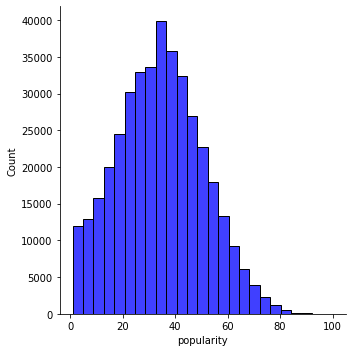

In [ ]:
sns.displot(tracks_df.popularity, color="b", bins=25)

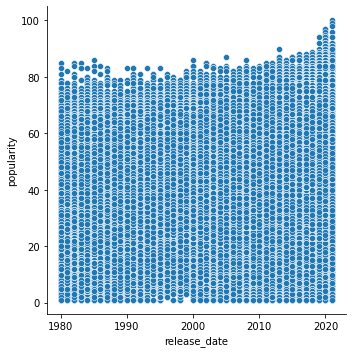

In [ ]:
sns.relplot(data=tracks_df, x="release_date", y="popularity")

In [ ]:
tracks_df.sort_values(by=['popularity'], ascending=False)

,id,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
37915,4iJyoBOLtHqaGxP12qzhQI,100,198082,1,2021,0.677,0.696,0,-6.181,1,0.1190,0.321000,0.000000,0.4200,0.4640,90.030,4
37916,7lPN2DXiMsVn7XUKtOW1CS,99,242014,1,2021,0.585,0.436,10,-8.761,1,0.0601,0.721000,0.000013,0.1050,0.1320,143.874,4
37917,3Ofmpyhv5UAQ70mENzB277,98,132780,0,2021,0.778,0.695,4,-6.865,0,0.0913,0.175000,0.000000,0.1500,0.4720,149.996,4
36928,5QO79kh1waicV47BqGRL3g,97,215627,1,2020,0.680,0.826,0,-5.487,1,0.0309,0.021200,0.000012,0.5430,0.6440,118.051,4
36929,6tDDoYIxWvMLTdKpjFkc1B,97,160191,0,2020,0.653,0.524,11,-9.016,0,0.0502,0.112000,0.000000,0.2030,0.5530,83.970,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,7HSqKrUk51iV7uFrXGXAoJ,1,217147,0,2005,0.508,0.159,10,-32.297,0,0.9350,0.784000,0.000000,0.7410,0.3860,173.801,3
26530,32cSCL60PqVg7naWPFIhuZ,1,248889,0,2013,0.505,0.969,8,-6.757,1,0.0459,0.000752,0.899000,0.1600,0.3500,135.007,4
26547,3twYH87xoaxT3YfgKwZB0O,1,215827,0,2013,0.458,0.977,5,-6.884,0,0.0485,0.000953,0.864000,0.3480,0.1840,138.976,4
26555,7F2tPUfgXkkGVrkgl06MiG,1,248951,0,2013,0.546,0.948,1,-7.417,1,0.0397,0.000030,0.673000,0.0878,0.2600,135.993,4


In [ ]:
(tracks_df.popularity==0).value_counts()

False    394390
Name: popularity, dtype: int64

Converting duration from millisecond to second on Spotify Tracks Dataset

In [ ]:
tracks_df['duration'] = tracks_df['duration_ms'].apply (lambda x : round(x/1000))
tracks_df.drop('duration_ms', inplace = True, axis=1)
tracks_df.duration.head()

0    160
1    160
2    142
3    157
4    187
Name: duration, dtype: int64

In [ ]:
tracks_df['duration'].describe()

count    394390.000000
mean        233.727582
std         106.037025
min          24.000000
25%         188.000000
50%         226.000000
75%         269.000000
max        5404.000000
Name: duration, dtype: float64

In [ ]:
sam = tracks_df.sample(int(0.004 * len(tracks_df)))
len(sam)

1577

Regression plot - Correlation between Loudness and Energy

[Text(0.5, 1.0, 'Loudness vs Energy Correlation')]

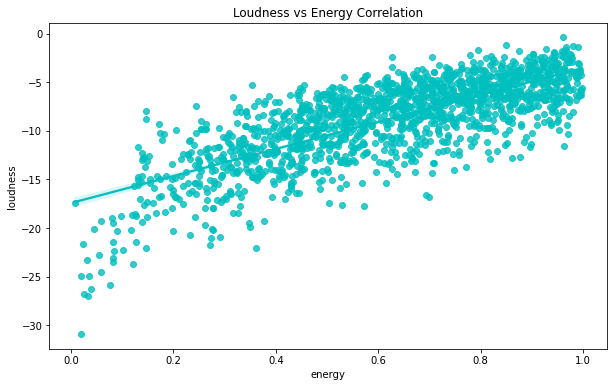

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(data=sam, y='loudness', x='energy', color='c').set(title='Loudness vs Energy Correlation')

Regression plot - Correlation between Popularity and Acousticness

[Text(0.5, 1.0, 'Popularity vs Acousticness Correlation')]

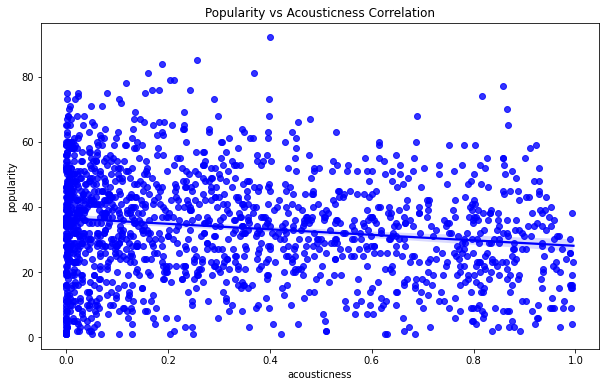

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(data=sam, y='popularity', x='acousticness', color='b').set(title='Popularity vs Acousticness Correlation')

Distibution plot - Visualize total number of songs on Spotify since 1992

---



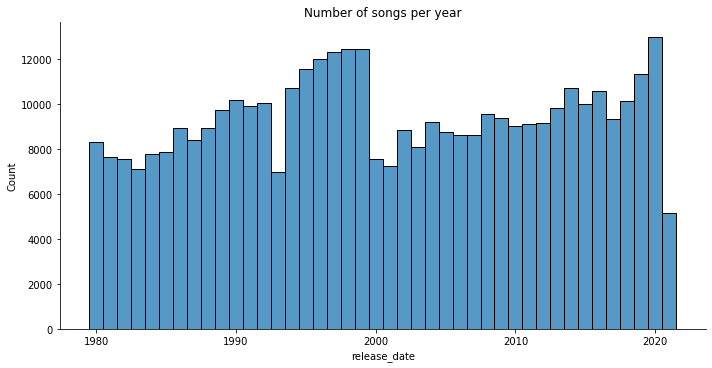

In [ ]:
sns.displot(tracks_df.release_date, discrete=True, aspect=2, height=5, kind='hist').set(title='Number of songs per year')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text major ticklabel objects>)

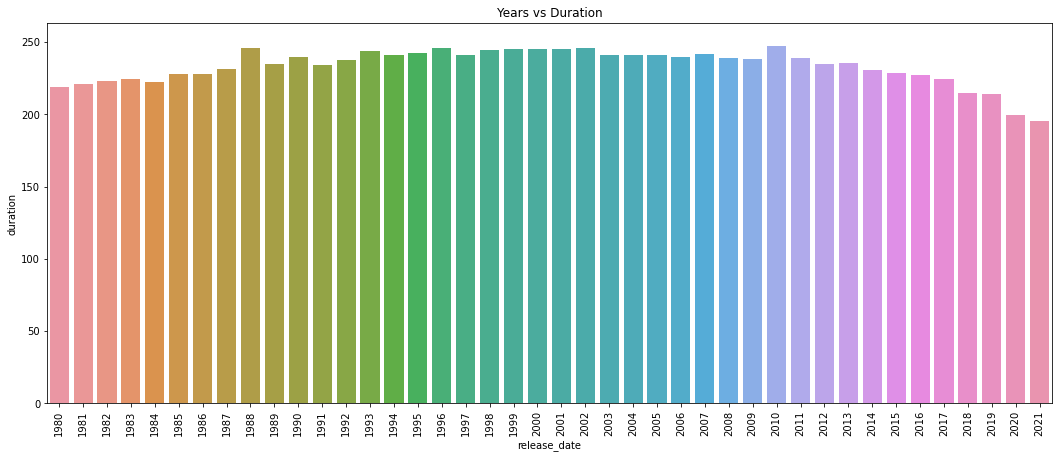

In [ ]:
total_dr = tracks_df.duration
fig_dims = (18,7)
fig, ax = plt.subplots(figsize=fig_dims)
fig = sns.barplot(x = tracks_df.release_date, y = total_dr, ax = ax, errwidth = False).set(title='Years vs Duration')
plt.xticks(rotation=90)

In [ ]:
tracks_df.rename(columns = {'duration_ms':'duration_s'}, inplace = True)

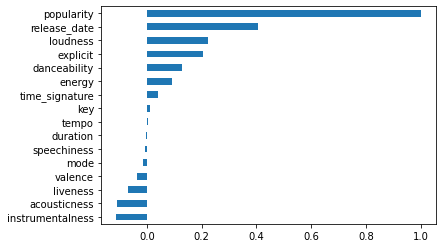

In [ ]:
tracks_df.corr()["popularity"].sort_values().plot.barh()

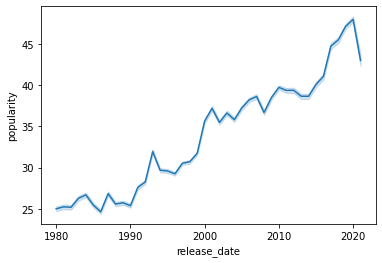

In [ ]:
sns.lineplot(x="release_date", y="popularity", data=tracks_df)

In [ ]:
# sns.lineplot(x="acousticness", y="popularity", data=track)

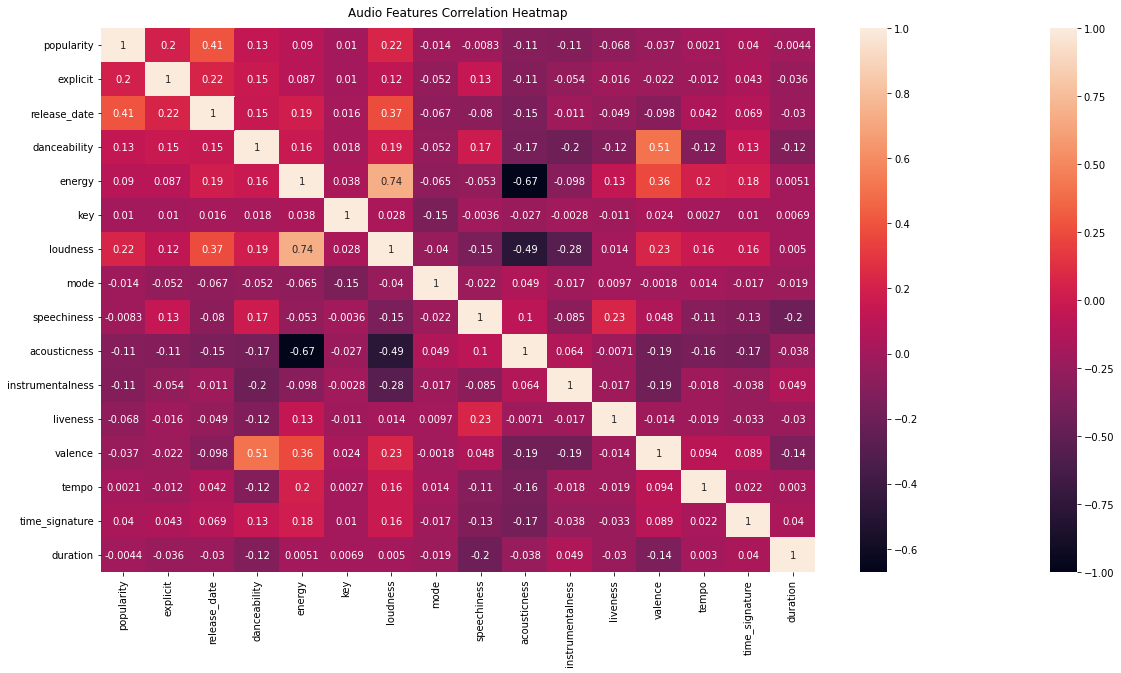

In [ ]:
plt.figure(figsize=(20, 10))

heatmap = sns.heatmap(tracks_df.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Audio Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

sns.heatmap(tracks_df.corr());

In [ ]:
tracks_df.describe().T

,count,mean,std,min,25%,50%,75%,max
popularity,394390.0,34.151183,16.401543,1.0,22.00000,34.000000,45.0000,100.000
explicit,394390.0,0.063653,0.244134,0.0,0.00000,0.000000,0.0000,1.000
release_date,394390.0,2001.017437,11.875793,1980.0,1991.00000,2000.000000,2012.0000,2021.000
danceability,394390.0,0.588449,0.160829,0.0,0.48600,0.602000,0.7050,0.991
energy,394390.0,0.609856,0.231649,0.0,0.44600,0.631000,0.8000,1.000
key,394390.0,5.269239,3.551335,0.0,2.00000,5.000000,9.0000,11.000
loudness,394390.0,-8.992621,4.482771,-60.0,-11.28400,-8.042000,-5.8290,2.534
mode,394390.0,0.639015,0.480287,0.0,0.00000,1.000000,1.0000,1.000
speechiness,394390.0,0.102347,0.169559,0.0,0.03330,0.044200,0.0793,0.969
acousticness,394390.0,0.339523,0.306666,0.0,0.05180,0.255000,0.5940,0.996


# *Grouping songs by 10 years*

In [ ]:
track_1980_1990 = tracks_df[(tracks_df['release_date'].astype(int) < 1990) & (tracks_df['release_date'].astype(int) >= 1920)].reset_index(drop=True)
track_1990_2000 = tracks_df[(tracks_df['release_date'].astype(int) < 2000) & (tracks_df['release_date'].astype(int) >= 1990)].reset_index(drop=True)
track_2000_2010 = tracks_df[(tracks_df['release_date'].astype(int) < 2010) & (tracks_df['release_date'].astype(int) >= 2000)].reset_index(drop=True)
track_2010_2021 = tracks_df[(tracks_df['release_date'].astype(int) < 2020) & (tracks_df['release_date'].astype(int) >= 2010)].reset_index(drop=True)

In [ ]:
track_2010_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99322 entries, 0 to 99321
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        99322 non-null  int64  
 1   explicit          99322 non-null  int64  
 2   release_date      99322 non-null  int64  
 3   danceability      99322 non-null  float64
 4   energy            99322 non-null  float64
 5   key               99322 non-null  int64  
 6   loudness          99322 non-null  float64
 7   mode              99322 non-null  int64  
 8   speechiness       99322 non-null  float64
 9   acousticness      99322 non-null  float64
 10  instrumentalness  99322 non-null  float64
 11  liveness          99322 non-null  float64
 12  valence           99322 non-null  float64
 13  tempo             99322 non-null  float64
 14  time_signature    99322 non-null  int64  
 15  duration          99322 non-null  int64  
dtypes: float64(9), int64(7)
memory usage: 12

In [ ]:
fig=make_subplots(rows=3,cols=3,subplot_titles=('<i>popularity', '<i>danceability', '<i>energy', '<i>loudness', '<i>speechiness', '<i>acousticness', '<i>liveness', '<i>valence', '<i>tempo'))
fig.add_trace(go.Histogram(x=track_2010_2021['popularity'],name='popularity'),row=1,col=1)
fig.add_trace(go.Histogram(x=track_2010_2021['danceability'],name='danceability'),row=1,col=2)
fig.add_trace(go.Histogram(x=track_2010_2021['energy'],name='energy'),row=1,col=3)
fig.add_trace(go.Histogram(x=track_2010_2021['loudness'],name='loudness'),row=2,col=1)
fig.add_trace(go.Histogram(x=track_2010_2021['speechiness'],name='speechiness'),row=2,col=2)
fig.add_trace(go.Histogram(x=track_2010_2021['acousticness'],name='acousticness'),row=2,col=3)
fig.add_trace(go.Histogram(x=track_2010_2021['liveness'],name='liveness'),row=3,col=1)
fig.add_trace(go.Histogram(x=track_2010_2021['valence'],name='valence'),row=3,col=2)
fig.add_trace(go.Histogram(x=track_2010_2021['tempo'],name='tempo'),row=3,col=3)
fig.update_layout(height=900,width=900,title_text='<b>Feature Distribution')
fig.update_layout(template='plotly_dark',title_x=0.5)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sns.displot(track_1920_1940.popularity, color="b", bins=25)
sns.displot(track_1940_1960.popularity, color="b", bins=25)
sns.displot(track_1960_1980.popularity, color="b", bins=25)
sns.displot(track_1980_2000.popularity, color="b", bins=25)
sns.displot(track_2000_2021.popularity, color="b", bins=25)

In [ ]:
track.release_date.describe()

count    203394.000000
mean       2010.945170
std           6.202101
min        2000.000000
25%        2006.000000
50%        2011.000000
75%        2016.000000
max        2021.000000
Name: release_date, dtype: float64

In [ ]:
track.release_date.value_counts()

2020    12990
1998    12475
1999    12455
1997    12334
1996    12024
        ...  
1923      103
1929       73
1924       70
1922        5
1900        1
Name: release_date, Length: 101, dtype: int64

# Outlier Detection

In [ ]:
tracks_df.sort_values(by="release_date")

,id,popularity,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration
203446,3w4LluSlQHXHoTH5QQodNz,15,0,1980,0.697,0.771,2,-9.982,1,0.0987,0.0324,0.000000,0.0759,0.962,152.374,4,205
203502,6MzIsyys9Ws1aXDjJjChNw,25,0,1980,0.484,0.598,2,-9.756,1,0.0283,0.2020,0.000073,0.6420,0.863,109.008,4,206
203503,73yhx3X96uO3jpNlAQLZwA,31,0,1980,0.504,0.449,1,-12.788,1,0.0331,0.0737,0.000000,0.3780,0.271,131.215,4,226
203504,0mAZnGbFzKY90dMzyzMp7G,9,0,1980,0.567,0.372,2,-10.855,1,0.0262,0.7730,0.000000,0.1750,0.747,90.754,4,159
203505,2cAkFA7H02EDUNvTngxRmI,8,0,1980,0.694,0.650,7,-12.610,1,0.0973,0.1180,0.000617,0.1340,0.967,124.726,4,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158953,5UlWJqt2iwFInXuNbEIJYg,45,0,2021,0.588,0.736,2,-6.339,1,0.0327,0.2830,0.000000,0.0977,0.444,98.028,4,241
158952,22H8nkDVSblurw8BcLHr4G,46,0,2021,0.499,0.475,11,-6.752,0,0.0251,0.7290,0.000000,0.1040,0.355,162.016,4,256
158951,6SvC0ocJPoolWLaEV8UE58,54,1,2021,0.776,0.692,2,-3.834,1,0.0555,0.0075,0.000000,0.0588,0.543,95.972,4,198
158965,46wDG6evLn2iPoQ0F8CUWk,68,0,2021,0.353,0.419,4,-6.260,1,0.0341,0.3650,0.000000,0.3500,0.122,134.334,4,317


ValueError: ignored

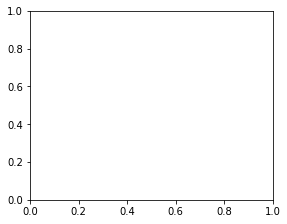

In [ ]:
plt.figure(figsize=(20,16))
for i in range(len(tracks_df.columns)):
    plt.subplot(4,4,i+1)
    sns.boxplot(data = tracks_df[tracks_df.columns[i]])
plt.show()

In [ ]:
tracks_df.tempo.describe()

Zero tempo data deleted

In [ ]:
zeroTempo = tracks_df[tracks_df['tempo'].astype(int) == 0].index
tracks_df.drop(zeroTempo, inplace=True)
track = tracks_df.reset_index(drop=True)

In [ ]:
def get_outlier_counts(df, treshold):
    df = df.copy()
    df.drop(['id'], axis=1, inplace=True)
    #Get z-score for specified treshold. shitft and scale, ne kadar mean den uzaklar ı hesaplarız.
    treshold_z_score = stats.norm.ppf(treshold) #norm distribution. ppf: percent point funct. scipy içindfe bir istatik func. cdf nin tersi

    #get the z-scores for each value in track 
    z_score_df = pd.DataFrame(np.abs(stats.zscore(df)), columns=df.columns)
    
    #compare df z-scores to the treshold, Return the count of outliers in each column
    return (z_score_df > treshold_z_score).sum(axis=0)

In [ ]:
# print(get_outlier_counts(track_1920_1940 , 0.999999995))
# print(get_outlier_counts(track_1940_1960  , 0.999999995))
# print(get_outlier_counts(track_1960_1980  , 0.999999995))
# print(get_outlier_counts(track_1980_2000  , 0.999999995))
get_outlier_counts(tracks_df , 0.999999995)

popularity             0
explicit               0
release_date           0
danceability           0
energy                 0
key                    0
loudness             403
mode                   0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
time_signature      3225
duration             932
dtype: int64

In [ ]:
def remove_outliers(df, treshold):

    df1 = df.copy()
    df1.drop(['id'], axis=1, inplace=True)

    #Get z-score for specified treshold
    treshold_z_score = stats.norm.ppf(treshold)

    #get the z-scores for each value in track and compare them to the treshold
    z_score_df = pd.DataFrame(np.abs(stats.zscore(df1)), columns=df1.columns)
    z_score_df.time_signature = treshold_z_score  # treshold is not needed for time signature

    z_score_df = z_score_df > treshold_z_score
    # Get indicies of outliers
    outliers = z_score_df.sum(axis=1) # her rowdaki outliers toplamı
    outliers = outliers > 0

    outliers_indicies = df1.index[outliers]

    #Drop outliers
    df = df.drop(outliers_indicies, axis=0).reset_index(drop=True)

    return df

In [ ]:
# track_1920_1940  = remove_outliers(track_1920_1940 , 0.999999995)
# track_1940_1960  = remove_outliers(track_1940_1960 , 0.999999995)
# track_1960_1980  = remove_outliers(track_1960_1980 , 0.999999995)
# track_1980_2000  = remove_outliers(track_1980_2000 , 0.999999995)
# track_2000_2021  = remove_outliers(track_2000_2021, 0.999999995)
tracks_df2 = remove_outliers(tracks_df, 0.999999995)

In [ ]:
tracks_df2

,id,popularity,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration
0,6catF1lDhNTjjGa2GxRQNN,56,0,2008,0.484,0.265,0,-11.101,1,0.0322,0.394,0.000000,0.1490,0.2850,113.564,3,160
1,6Pkt6qVikqPBt9bEQy8iTz,41,0,2020,0.671,0.867,2,-2.706,1,0.0571,0.436,0.000000,0.1390,0.8390,120.689,4,160
2,4aSw1QJIMwYSoDEgzgdCJL,40,0,2008,0.405,0.365,6,-10.226,0,0.0289,0.255,0.000005,0.1630,0.5880,104.536,4,142
3,0ZMMtH875IR2TfkyC4PolD,34,0,2008,0.477,0.352,1,-14.165,1,0.0300,0.406,0.000000,0.1220,0.4780,106.773,4,157
4,1hx7X9cMXHWJjknb9O6Ava,26,0,2018,0.319,0.201,7,-17.796,1,0.0623,0.887,0.000000,0.9040,0.2390,117.153,3,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392851,5rgu12WBIHQtvej2MdHSH0,50,0,2020,0.560,0.518,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,258
392852,0NuWgxEp51CutD2pJoF4OM,72,0,2020,0.765,0.663,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,153
392853,27Y1N4Q4U3EfDU5Ubw8ws2,70,0,2020,0.535,0.314,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,188
392854,45XJsGpFTyzbzeWK8VzR8S,58,0,2021,0.696,0.615,10,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4,142


In [ ]:
plt.figure(figsize=(20,16))
for i in range(len(tracks_df.columns)):
    plt.subplot(4,4,i+1)
    sns.boxplot(data = tracks_df[tracks_df.columns[i]])
plt.show()

In [ ]:
tracks_df2.time_signature.describe()

count    392856.000000
mean          3.907615
std           0.403315
min           0.000000
25%           4.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: time_signature, dtype: float64

# **Normalization**

In [ ]:
def standardize_array(array):
  mean = sum(array) / len(array)
  std = np.sqrt(
    sum((x - mean) ** 2 for x in array) / (len(array) - 1)
  )

  return [(x - mean) / std for x in array]


In [ ]:
import json

def preprocess_inputs(df, outliers=True, treshold=1):
    df = df.copy()
    if outliers == False:
        df = remove_outliers(df, treshold)
    

    
    y = df['popularity'].values
    X = df.drop(['popularity', 'release_date'], axis=1).values

    # Split your data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
        

    # Create a list to store the train and test data
    data = []

    print(X_train)
    # Iterate through the train data and append it to the list
    for i, x in enumerate(X_train[:,0]):
      data.append({'id': x, 'feature': 0})

    # Iterate through the test data and append it to the list
    for i, x in enumerate(X_test[:,0]):
      data.append({'id': x, 'feature': 1})

    # Encode the data as a JSON object
    json_data = json.dumps(data)

    # Write the JSON object to a file
    with open('data.json', 'w') as f:
      f.write(json_data)

    X_train = df.drop(['id'], axis=1).values
    X_test = df.drop(['id'], axis=1).values  
    
    
    # Scaling
    X_train = standardize_array(X_train)
    X_train_scaled = np.array(X_train)

    X_test = standardize_array(X_test)
    X_test_scaled = np.array(X_test)

    # Create a PCA transformer with n_components=0.95 to preserve 95% of the variance
    pca = PCA(n_components=0.95)

    # Fit the transformer to the training data and transform the training and test data
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    return X_train_pca, X_test_pca, y_train, y_test


In [ ]:
#outlier_x_train, outlier_x_test, outlier_y_train, outlier_y_test = preprocess_inputs(track, outliers=False, treshold=0.999999995)
# x_train1, x_test1, y_train1, y_test1 = preprocess_inputs(track_1920_1940, outliers=False)
# x_train2, x_test2, y_train2, y_test2 = preprocess_inputs(track_1940_1960, outliers=False)
# x_train3, x_test3, y_train3, y_test3 = preprocess_inputs(track_1960_1980, outliers=False)
# x_train4, x_test4, y_train4, y_test4 = preprocess_inputs(track_1980_2000, outliers=False)
# x_train5, x_test5, y_train5, y_test5 = preprocess_inputs(df, outliers=False)
# x_train_1, x_test_1, y_train_1, y_test_1 = preprocess_inputs(track_1920_1940, outliers=True)
# x_train_2, x_test_2, y_train_2, y_test_2 = preprocess_inputs(track_1940_1960, outliers=True)
# x_train_3, x_test_3, y_train_3, y_test_3 = preprocess_inputs(track_1960_1980, outliers=True)
# x_train_4, x_test_4, y_train_4, y_test_4 = preprocess_inputs(track_1980_2000, outliers=True)
# x_train_5, x_test_5, y_train_5, y_test_5 = preprocess_inputs(track_2000_2021, outliers=True)

x_train, x_test, y_train, y_test = preprocess_inputs(tracks_df, outliers=False)

[['51HSsbQvuA6U9M1DwjcEnP' 0 0.436 ... 79.44 4 248]
 ['4tetmp1j27qSDwGorUIwpk' 1 0.824 ... 90.249 4 184]
 ['6490IpuzqAZSsYO3KJ9xG0' 0 0.631 ... 68.234 4 237]
 ...
 ['4EbNb50WVFg4enZEzfLxEm' 0 0.746 ... 94.011 4 246]
 ['6eyKldvrtmRfTyie4i6lY5' 0 0.603 ... 78.933 4 269]
 ['4E8YiVsfel2YSiCySkiQaG' 0 0.324 ... 179.929 4 163]]


# **Test outlier detection**

In [ ]:
outlier_model = LinearRegression()
outlier_model.fit(x_train, y_train)

outlier_model_acc = outlier_model.score(x_test, y_test)

print("Test acc - outliers: {:.5f}".format(outlier_model_acc * 100))

Test acc - outliers: 9.46569


In [ ]:
no_outlier_model = LinearRegression()
no_outlier_model.fit(x_train, y_train)

no_outlier_model_acc = no_outlier_model.score(x_test, y_test)

print("Test acc - outliers: {:.5f}".format(no_outlier_model_acc * 100))

Test acc - outliers: 9.46569


# **Model**

In [ ]:
# Create a neural network model
model = Sequential()

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [ ]:
# model1 = model()
# model2 = model()
# model3 = model()
# model4 = model()
# model5 = model() 

model.fit(x_train, y_train,  epochs=10, batch_size=10, validation_data=(x_test, y_test))
# model2.fit(x_train_2, y_train_2, epochs=130, batch_size=1000)
# model3.fit(x_train_3, y_train_3, epochs=130, batch_size=1000)
# model4.fit(x_train_4, y_train_4, epochs=130, batch_size=1000)
# model5.fit(x_train_5, y_train_5, epochs=130, batch_size=1000)

Epoch 1/10
31429/31429 [==============================] - 71s 2ms/step - loss: 12.3227 - mae: 12.3227 - val_loss: 12.0427 - val_mae: 12.0427
Epoch 2/10
31429/31429 [==============================] - 66s 2ms/step - loss: 12.0112 - mae: 12.0112 - val_loss: 11.9767 - val_mae: 11.9767
Epoch 3/10
31429/31429 [==============================] - 69s 2ms/step - loss: 11.9461 - mae: 11.9461 - val_loss: 11.9244 - val_mae: 11.9244
Epoch 4/10
31429/31429 [==============================] - 66s 2ms/step - loss: 11.9067 - mae: 11.9067 - val_loss: 11.8932 - val_mae: 11.8932
Epoch 5/10
31429/31429 [==============================] - 65s 2ms/step - loss: 11.8778 - mae: 11.8778 - val_loss: 11.9022 - val_mae: 11.9022
Epoch 6/10
31429/31429 [==============================] - 65s 2ms/step - loss: 11.8565 - mae: 11.8565 - val_loss: 11.8682 - val_mae: 11.8682
Epoch 7/10
31429/31429 [==============================] - 67s 2ms/step - loss: 11.8383 - mae: 11.8383 - val_loss: 11.8573 - val_mae: 11.8573
Epoch 8/10
31

In [ ]:
y_pred = model.predict(x_test)

2456/2456 [==============================] - 3s 1ms/step


In [ ]:
# Evaluate the model's performance
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score)

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 120       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.save('model1.h5')
# model2.save('model2.h5')
# model3.save('model3.h5')
# model4.save('model4.h5')
# model5.save('model5.h5')

# Ensemble Learning

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor


# Build the base models
model1 = RandomForestRegressor(n_estimators=10)
model2 = GradientBoostingRegressor(n_estimators=10)
model3 = BaggingRegressor(n_estimators=10)
model4 = AdaBoostRegressor(n_estimators=10)

# Build the meta-model
meta_model = LinearRegression()

# Stack the base models and the meta-model
stacking_regressor = StackingRegressor(
    estimators=[("model1", model1), ("model2", model2), ("model3", model3), ("model4", model4)],
    final_estimator=meta_model
)

# Fit the stacked regressor to the training data
history = stacking_regressor.fit(x_train, y_train)

# Evaluate the stacked regressor on the test data
score = stacking_regressor.score(x_test, y_test)
print("Test score:", score)

Test score: 0.29531042206843716


# Model Convert to Json and Save

In [ ]:
!sudo pip3 install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!sudo tensorflowjs_converter

2023-01-01 10:45:56.023140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 10:45:58.676865: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-01 10:45:58.677223: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-01 10:45:58.677273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
!tensorflowjs_converter --input_format=keras '/content/model1.h5' "/content/json"

2023-01-01 10:46:40.466241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-01 10:46:40.466366: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-01 10:46:40.466384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# Model Loss

In [ ]:
loss = model1.history.history["loss"]  

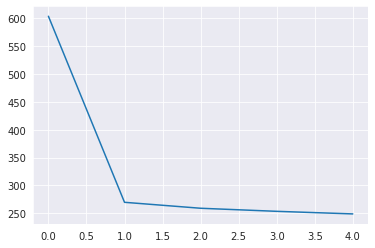

In [ ]:
sns.lineplot(x=range(len(loss)), y=loss)

In [ ]:
trainLoss = model1.evaluate(x_train, y_train, verbose=0)

In [ ]:
testLoss = model1.evaluate(x_test, y_test, verbose=0)

In [1]:
trainLoss

NameError: ignored

In [ ]:
testLoss

245.7476348876953

In [ ]:
y_test[1]

8

In [ ]:
testTahminleri = model1.predict(test)

1/1 [==============================] - 0s 32ms/step


In [ ]:
testTahminleri    

array([[31.91389]], dtype=float32)

In [ ]:
ActualDf = pd.DataFrame(y_test, columns=["Actual Y"])

In [ ]:
ActualDf

,Actual Y
0,39
1,8
2,14
3,3
4,29
...,...
187757,30
187758,61
187759,39
187760,44


In [ ]:
testTahminleri = pd.Series(testTahminleri.reshape(187762))

ValueError: ignored

In [ ]:
testTahminleri

array([[21.801224]], dtype=float32)

In [ ]:
tahminDf = pd.concat([ActualDf, testTahminleri], axis=1)

TypeError: ignored

In [ ]:
tahminDf.columns = ["Actual Y", "Predicted Y"]

In [ ]:
tahminDf

,Actual Y,Predicted Y
0,39,31.610464
1,8,10.928338
2,14,28.609173
3,3,21.779411
4,29,27.574560
...,...,...
187757,30,23.742100
187758,61,25.935816
187759,39,35.902298
187760,44,35.321800


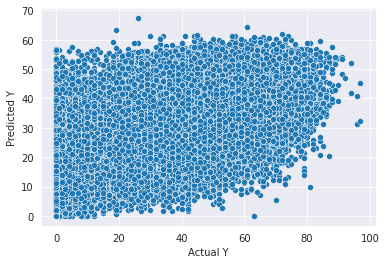

In [ ]:
sns.scatterplot(x = "Actual Y", y= "Predicted Y", data=tahminDf) 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
mean_absolute_error(tahminDf["Actual Y"], tahminDf["Predicted Y"])

12.313298957461402

In [ ]:
mean_squared_error(tahminDf["Actual Y"], tahminDf["Predicted Y"])

235.49598738653128

In [ ]:
from tensorflow.keras.models import load_model
model.save("song_popularity.h5")

In [ ]:
#sonradan çağırma
myModel = load_model("song_popularity.h5")
myModel.predict(newSong)

In [ ]:
from xgboost import XGBRegressor


model = XGBRegressor()
model.fit(outlier_x_train, outlier_y_train)
# make predictions for test data
y_pred = model.predict(outlier_x_test)
accuracy = model.score(outlier_x_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[12:47:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: 100.00%
